## Visualizing Original Geoparser - By Years

In this case, we have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix)  using the original language model for finding the Name Entities of all the books of a particular edition, and select the ones regarding with places. Later, once we have the locations entities, it uses the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: original`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/results_paper/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [41]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [22]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [86]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [500]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.5, top=0.95)
    fig.set_size_inches(20, 30)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned using the Original Geoparser ', fontsize = 20)
    else:
        fig.suptitle('15 Places most mentioned but not resolved using the Original Geoparser', fontsize = 20)
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='orange')
            axs[i,0].set_title('Year %s' %y)
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='coral')
            axs[i,0].set_title('Year %s' %y)
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']))
        axs[i,0].set_ylabel('Frequency of Places') 
        i=i +1 

In [515]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    #list_places = df_group_places_years_final.Place.unique()
    for pl in list_places:
        data=df.loc[df['Place']== pl].reset_index()
        plt.plot(data["count"], lw=line_weight, alpha=alpha, label=pl, marker='d')
    plt.xticks(np.arange(len(list_years)),list_years, rotation=50)  
    plt.title('Yearly cumulative plot of selected places' )
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places')
    plt.xlabel("Years")
    plt.show()
      
       

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeter"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: geoparser_original
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


In [369]:
results=read_query_results('geoparser_original_total')

In [370]:
df_total= geresolution_dataframe(results)

year 1848
year 1828
year 1883
year 1803
year 1901
year 1882
year 1846
year 1825
year 1806
year 1838
year 1842
year 1868


In [371]:
df_total.head(15)

,Latitude,Longitude,Place,Page,Year
0,33.64836,-98.46944999999999,Scotland,Page5,1848
1,42.5153725,-71.1144984,SCOTLAND,Page7,1848
2,51.64875,-0.0974,LONDON,Page7,1848
3,-43.2166667,171.6833333,LEITH,Page8,1848
4,,,ILLERAY,Page9,1848
5,54.9333333,-4.85,New Luce,Page9,1848
6,-23.41667,43.66667,ILAY,Page9,1848
7,55.2,-4.6666667,Carrick,Page9,1848
8,54.6585,-5.6725,Ireland,Page9,1848
9,56.6333333,-6.5666667,Coll,Page9,1848


**Important: Number of Places that has been identified!**

In [372]:
df_total[["Place"]].count()

Place    491756
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [373]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [374]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [375]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

**Important: Number of Places that has been identified but not resolved!**

In [326]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude     55672
Longitude    55672
Place        55672
Page         55672
Year         55672
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [327]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     436084
Longitude    436084
Place        436084
Page         436084
Year         436084
dtype: int64

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [328]:
df_resolved = df_total[df_total['Latitude'] != '']

In [329]:
df_resolved.count()

Latitude     436084
Longitude    436084
Place        436084
Page         436084
Year         436084
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [330]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [493]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,33.64836,-98.46944999999999,Scotland,Page5,1848
1,42.5153725,-71.1144984,Scotland,Page7,1848
2,51.64875,-0.0974,London,Page7,1848
3,-43.2166667,171.6833333,Leith,Page8,1848
5,54.9333333,-4.85,New luce,Page9,1848
6,-23.41667,43.66667,Ilay,Page9,1848
7,55.2,-4.6666667,Carrick,Page9,1848
8,54.6585,-5.6725,Ireland,Page9,1848
9,56.6333333,-6.5666667,Coll,Page9,1848
10,55.25,-4.6666667,Ayrshire,Page9,1848


**Important: Calculating the number of georesolved places by year**

In [332]:
df_capitalized.groupby("Year").count()

,Latitude,Longitude,Place,Page
Year,,,,
1803,11773,11773,11773,11773
1806,13348,13348,13348,13348
1825,8569,8569,8569,8569
1828,2184,2184,2184,2184
1838,28050,28050,28050,28050
1842,61035,61035,61035,61035
1846,30669,30669,30669,30669
1848,29932,29932,29932,29932
1868,72227,72227,72227,72227


### Visualizing the 15 places more mentioned (and resolved) per year

In [489]:
mpl.rcParams['figure.dpi']=300
years_list = df_capitalized['Year'].unique()
filter_list=['Earth', 'The moon', 'Meridian', 'Jupiter', 'Venus', 'Kingdom']
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude','Year']].groupby(['Latitude', 'Longitude','Year'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    place_label, place_freq = label_freq_places(df_filter_year, df_max_geolocations, filter_list)
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

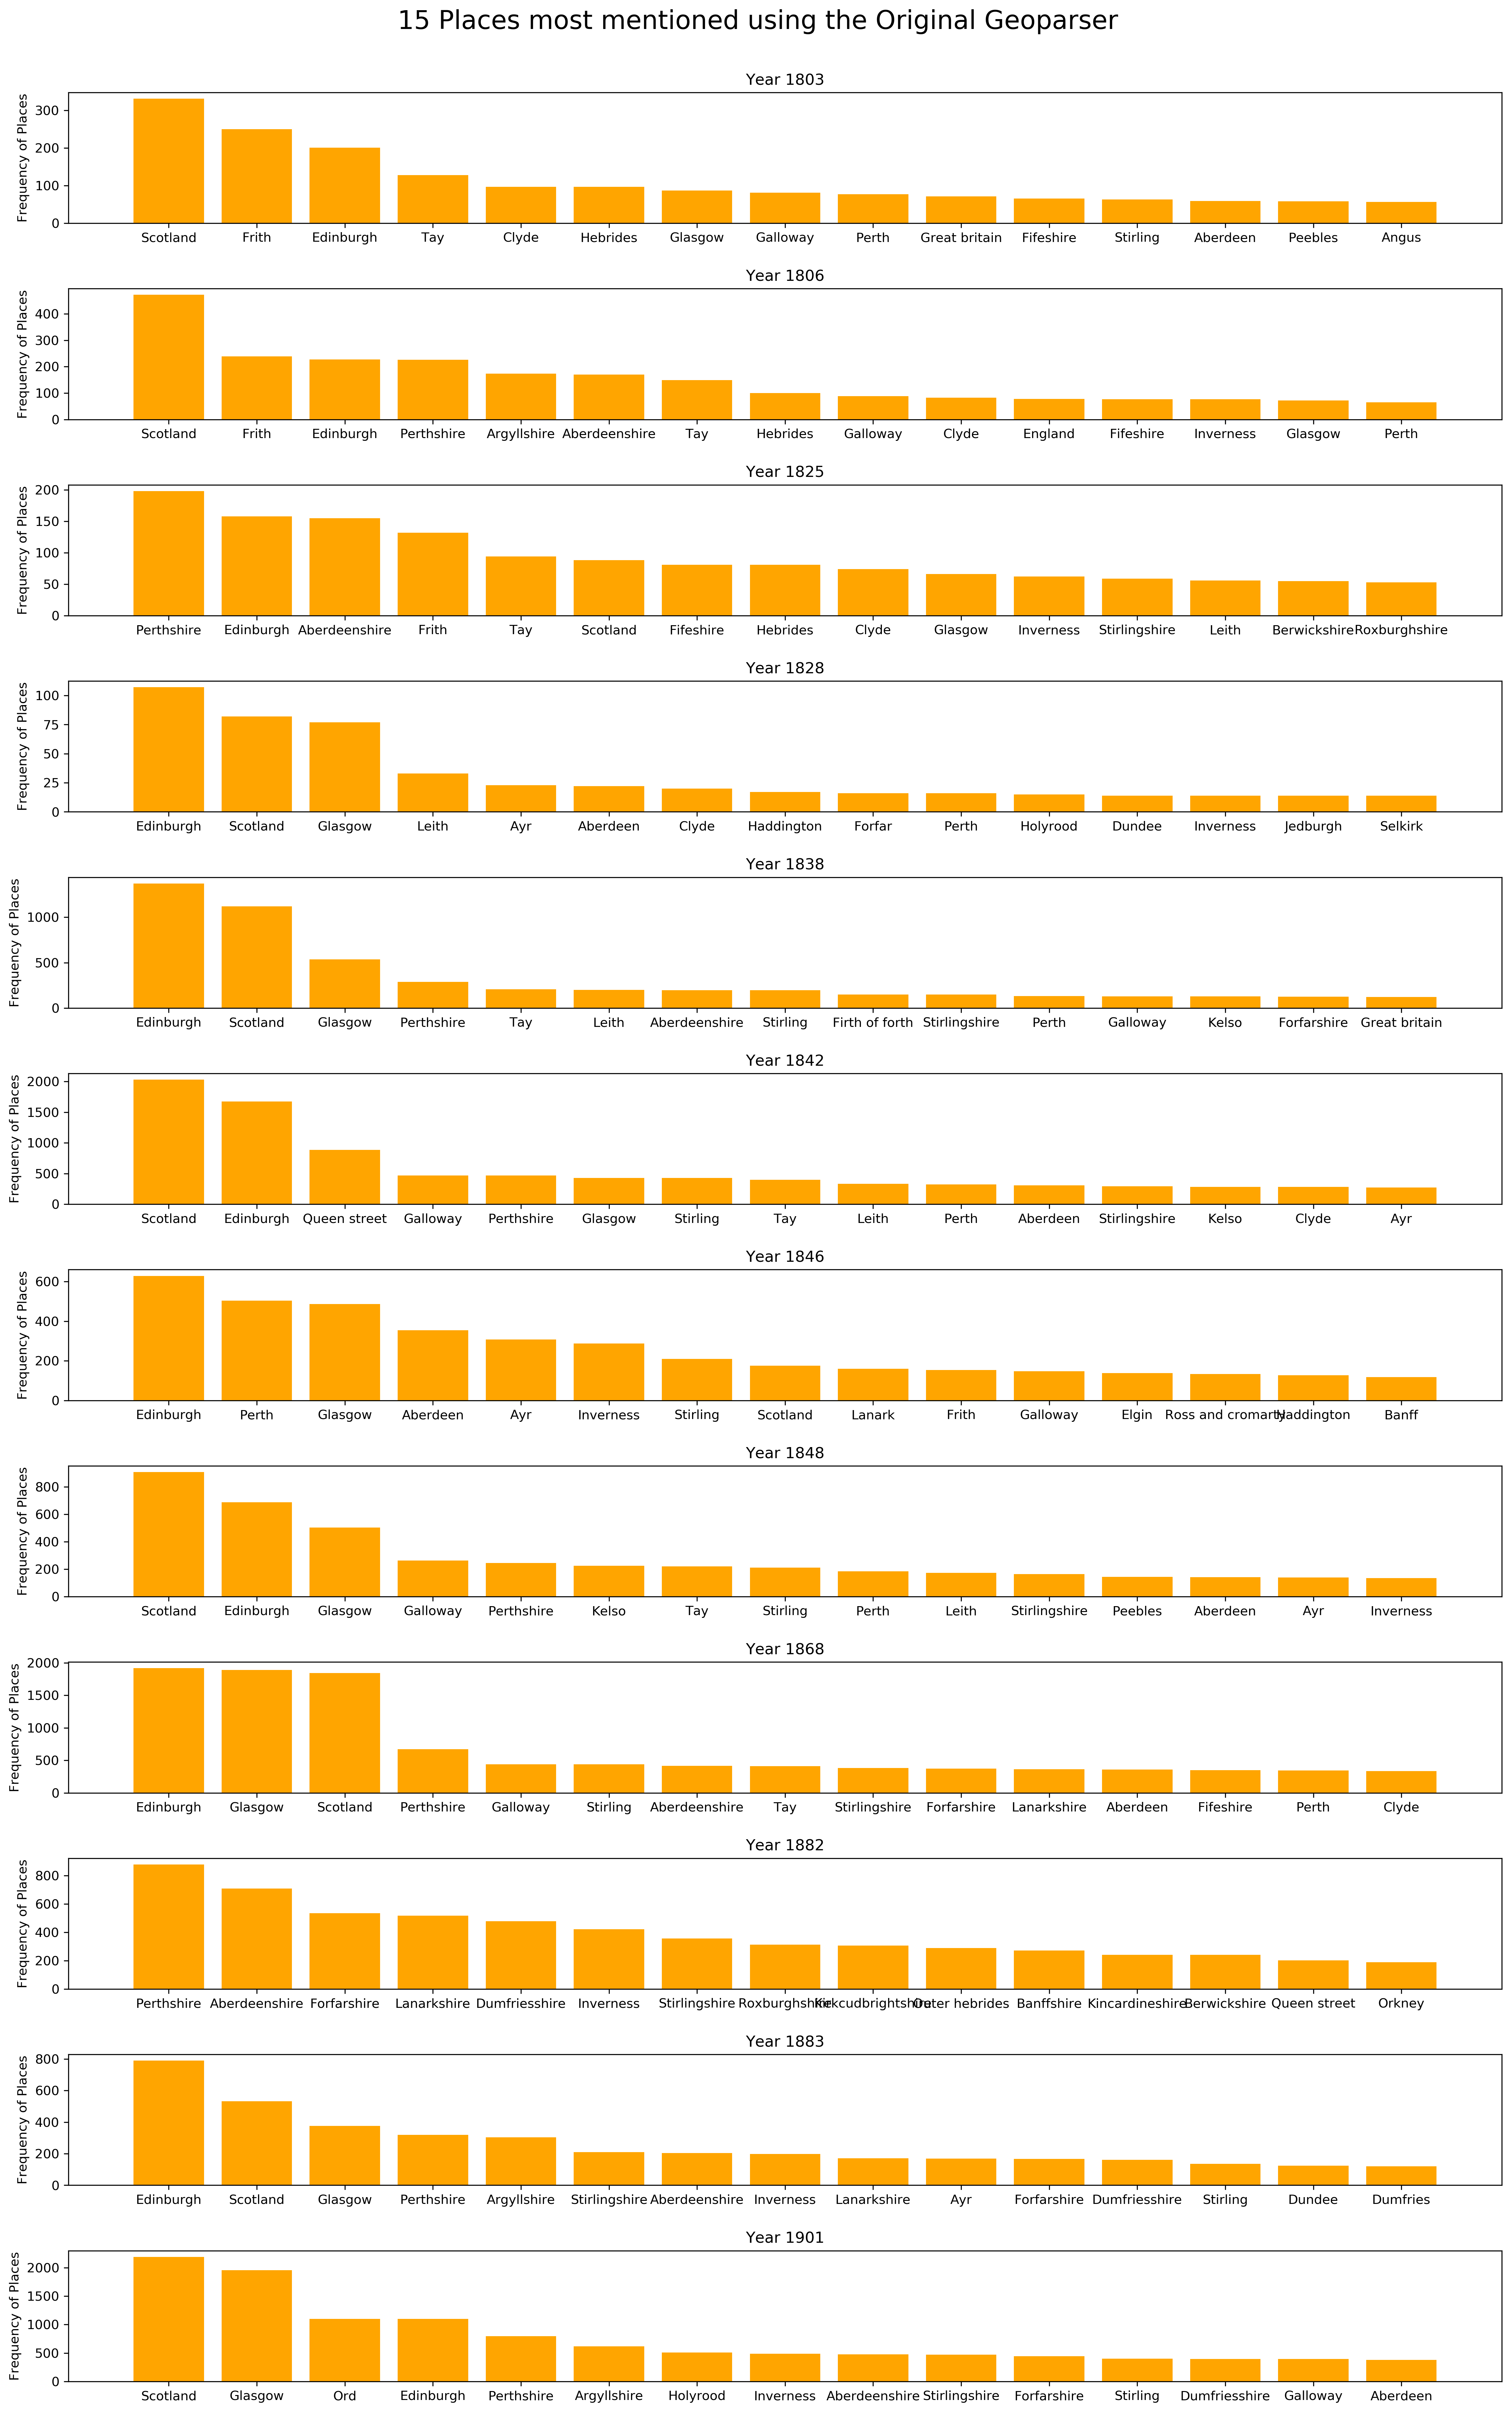

In [501]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

In [336]:
df_group_places_years["1828"]

,Place,count
4,Edinburgh,107
13,Scotland,82
6,Glasgow,77
11,Leith,33
1,Ayr,23
0,Aberdeen,22
2,Clyde,20
7,Haddington,17
5,Forfar,16
12,Perth,16


In [337]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [344]:
df_group_places_years_final

Place  count
1803 12       Scotland    331
     5           Frith    250
     3       Edinburgh    201
     14            Tay    128
     2           Clyde     97
     9        Hebrides     97
     7         Glasgow     87
     6        Galloway     81
     11          Perth     77
     8   Great britain     71
     4       Fifeshire     66
     13       Stirling     63
     0        Aberdeen     59
     10        Peebles     58
     1           Angus     57
1806 13       Scotland    472
     6           Frith    239
     3       Edinburgh    227
     12     Perthshire    226
     1     Argyllshire    173
     0   Aberdeenshire    170
     14            Tay    149
     9        Hebrides    100
     7        Galloway     88
     2           Clyde     82
     4         England     78
     5       Fifeshire     77
     10      Inverness     77
     8         Glasgow     72
     11          Perth     65
...                ...    ...
1883 6       Edinburgh    789
     12       Scotland    532
     8         Glasgow    375
     11     Perthshire    319
     1     Argyllshire    304
     14  Stirlingshire    209
     0   Aberdeenshire    203
     9       Inverness    198
     10    Lanarkshire    170
     2             Ayr    168
     7     Forfarshire    166
     4   Dumfriesshire    160
     13       Stirling    136
     5          Dundee    123
     3        Dumfries    119
1901 12       Scotland   2189
     7         Glasgow   1953
     10            Ord   1101
     4       Edinburgh   1100
     11     Perthshire    796
     2     Argyllshire    615
     8        Holyrood    510
     9       Inverness    486
     1   Aberdeenshire    478
     14  Stirlingshire    469
     5     Forfarshire    442
     13       Stirling    399
     3   Dumfriesshire    397
     6        Galloway    397
     0        Aberdeen    379

[180 rows x 2 columns]

In [339]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']

,,Place,count
1803,3,Edinburgh,201
1806,3,Edinburgh,227
1825,3,Edinburgh,158
1828,4,Edinburgh,107
1838,1,Edinburgh,1372
1842,3,Edinburgh,1673
1846,3,Edinburgh,629
1848,2,Edinburgh,687
1868,3,Edinburgh,1915
1883,6,Edinburgh,789


In [340]:
df_group_places_years_final.Place.unique()

array(['Scotland', 'Frith', 'Edinburgh', 'Tay', 'Clyde', 'Hebrides',
       'Glasgow', 'Galloway', 'Perth', 'Great britain', 'Fifeshire',
       'Stirling', 'Aberdeen', 'Peebles', 'Angus', 'Perthshire',
       'Argyllshire', 'Aberdeenshire', 'England', 'Inverness',
       'Stirlingshire', 'Leith', 'Berwickshire', 'Roxburghshire', 'Ayr',
       'Haddington', 'Forfar', 'Holyrood', 'Dundee', 'Jedburgh', 'Selkirk',
       'Firth of forth', 'Kelso', 'Forfarshire', 'Queen street', 'Lanark',
       'Elgin', 'Ross and cromarty', 'Banff', 'Lanarkshire',
       'Dumfriesshire', 'Kirkcudbrightshire', 'Outer hebrides',
       'Banffshire', 'Kincardineshire', 'Orkney', 'Dumfries', 'Ord'], dtype=object)

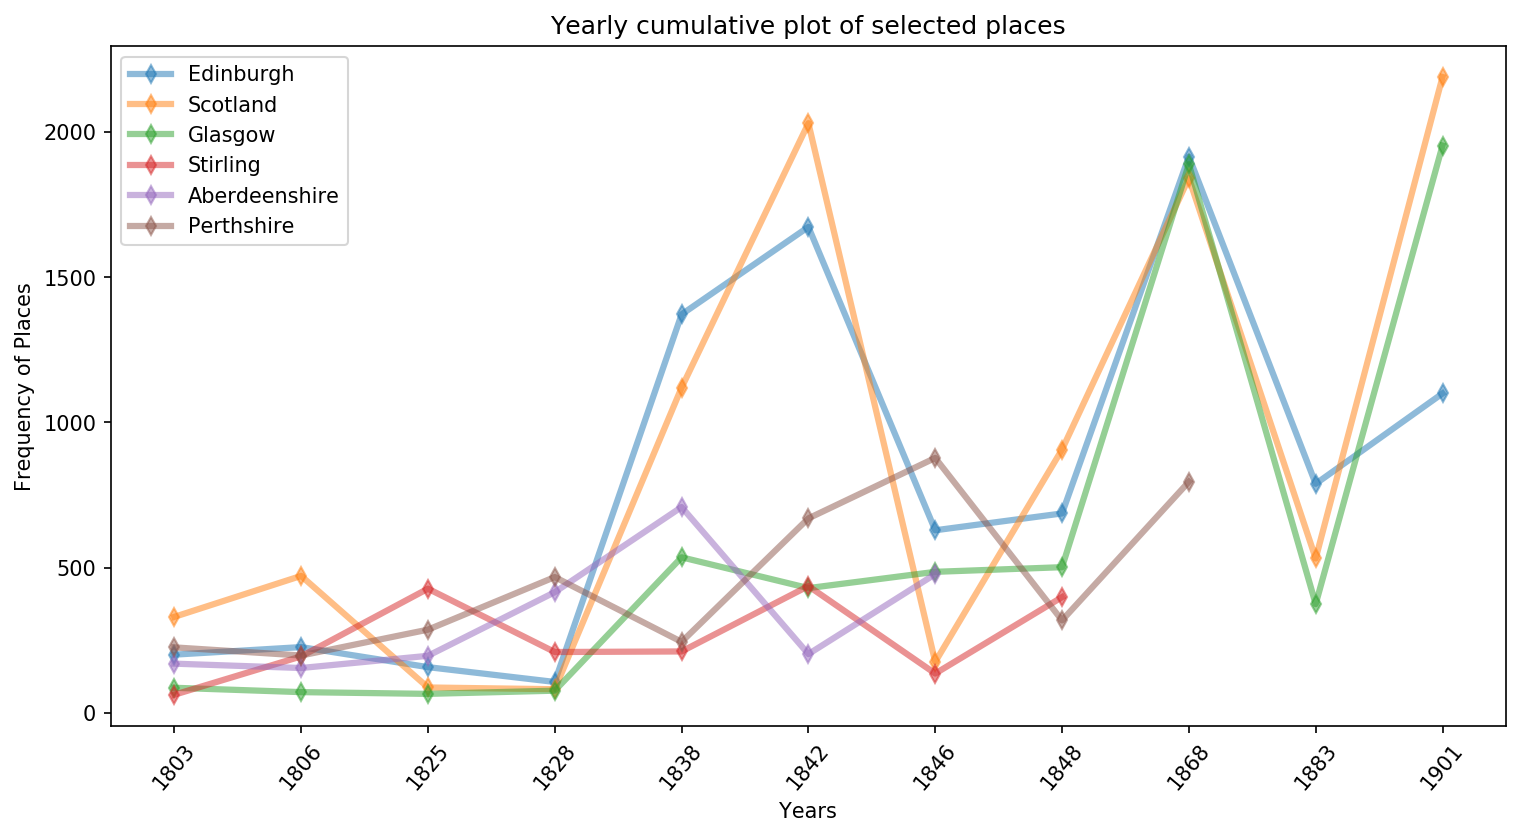

In [516]:
#df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']
mpl.rcParams['figure.dpi']=150
list_places=["Edinburgh", "Scotland", "Glasgow", "Stirling", "Aberdeenshire", "Perthshire"]
cumulative_plot(df_group_places_years_final, list_places, list_years)